# SPECIES PREDICTION MODEL PIPELINE (Deep Learning)

## Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("../species_prediction_model/data/field_big.csv")
df.head()

,watershed,river,site,method,local,water_temp_start,fork_length_mm,species
0,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co
1,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co
2,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co
3,englishman,center creek,center creek,smolt trap,in-river,10.2,86.0,co
4,englishman,center creek,center creek,smolt trap,in-river,10.2,87.0,co


In [3]:
df.isnull().sum()

watershed               0
river                   0
site                    0
method               2431
local                2901
water_temp_start    22583
fork_length_mm        145
species                56
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.species.unique()

array(['co', 'rbt', 'stl', 'ct', 'bt', 'ck', 'cm'], dtype=object)

In [9]:
fish_features = pd.read_csv("../species_prediction_model/data/fish_features.csv", index_col=None)
fish_features

,species,eye_size,snout_shape,parr_marks,parr_marks_length,spotting_density,fin_type
0,ck,large,pointy,slightly faded,long,medium,anal fin
1,co,large,short and blunt,slightly faded,long,medium,anal fin
2,cm,medium,NaN,faded,short,medium,caudal fin
3,pink,medium,NaN,NaN,NaN,NaN,caudal fin
4,so,very large,NaN,slightly faded,irregular,NaN,caudal fin
5,stl,small,short and rounded,faded,short,high,caudal fin
6,ct,small,long and pointy,faded,short,high,caudal fin
7,rbt,small,short and rounded,NaN,short,high,caudal fin


In [10]:
full = df.merge(fish_features, how='left',on='species')
full.head()

,watershed,river,site,method,local,water_temp_start,fork_length_mm,species,eye_size,snout_shape,parr_marks,parr_marks_length,spotting_density,fin_type
0,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co,large,short and blunt,slightly faded,long,medium,anal fin
1,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co,large,short and blunt,slightly faded,long,medium,anal fin
2,englishman,center creek,center creek,smolt trap,in-river,10.2,85.0,co,large,short and blunt,slightly faded,long,medium,anal fin
3,englishman,center creek,center creek,smolt trap,in-river,10.2,86.0,co,large,short and blunt,slightly faded,long,medium,anal fin
4,englishman,center creek,center creek,smolt trap,in-river,10.2,87.0,co,large,short and blunt,slightly faded,long,medium,anal fin


In [11]:
full = full.replace(np.nan, None)
full.isnull().sum()

watershed            0
river                0
site                 0
method               0
local                0
water_temp_start     0
fork_length_mm       0
species              0
eye_size             0
snout_shape          0
parr_marks           0
parr_marks_length    0
spotting_density     0
fin_type             0
dtype: int64

In [13]:
co_sampled = full[full['species'] == 'co'].sample(n=500, random_state=42)
ck_sampled = full[full['species'] == 'ck'].sample(n=500, random_state=42)
labels_to_filter = ['stl', 'ct', 'rbt', 'cm']
others_combined = full[full['species'].isin(labels_to_filter)]
others_combined['species'].value_counts()

stl    479
ct     479
rbt    449
cm      10
Name: species, dtype: int64

In [15]:
full_small = pd.concat([co_sampled, ck_sampled, others_combined], axis=0)
full_small = full_small.reset_index(drop=True)
full_small['species'].value_counts()

co     500
ck     500
stl    479
ct     479
rbt    449
cm      10
Name: species, dtype: int64

## Pipeline

In [16]:
X = full_small.drop('species', axis = 1)
y = full_small['species']

In [17]:
numeric_feats = ["fork_length_mm"]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local", "eye_size", "snout_shape", "parr_marks", 
                     "parr_marks_length", "spotting_density", "fin_type"]  # apply one-hot encoding

In [18]:
ct = make_column_transformer (    
    (StandardScaler(), numeric_feats),       
    (OneHotEncoder(), categorical_feats)
)

In [19]:
transformed = ct.fit_transform(X)

In [20]:
column_names = (
    numeric_feats
    # + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['fork_length_mm',
 'watershed_cowichan',
 'watershed_englishman',
 'watershed_nanaimo',
 'watershed_puntledge',
 'river_center creek',
 'river_cowichan',
 'river_englishman',
 'river_haslam creek',
 'river_nanaimo',
 'river_puntledge',
 'river_shelly creek',
 'site_70.2',
 'site_above tsolum',
 'site_cedar bridge',
 'site_center creek',
 'site_condensory bridge',
 'site_cow bay',
 'site_hamilton ave',
 'site_jack point',
 'site_little mexico',
 'site_living forest',
 'site_mainstem fence',
 'site_martindale rd',
 'site_newcastle',
 'site_side channel',
 'site_skutz',
 'site_t-bone road',
 'site_tsolum confluence',
 'site_vimy pool',
 'method_beach seine',
 'method_g-trap',
 'method_rst',
 'method_smolt trap',
 'local_in-river',
 'local_marine',
 'eye_size_large',
 'eye_size_medium',
 'eye_size_small',
 'snout_shape_long and pointy',
 'snout_shape_pointy',
 'snout_shape_short and blunt',
 'snout_shape_short and rounded',
 'parr_marks_faded',
 'parr_marks_slightly faded',
 'parr_marks_l

In [22]:
X_transformed = pd.DataFrame.sparse.from_spmatrix(transformed, columns=column_names)
X_transformed.head()

,fork_length_mm,watershed_cowichan,watershed_englishman,watershed_nanaimo,watershed_puntledge,river_center creek,river_cowichan,river_englishman,river_haslam creek,river_nanaimo,...,snout_shape_short and blunt,snout_shape_short and rounded,parr_marks_faded,parr_marks_slightly faded,parr_marks_length_long,parr_marks_length_short,spotting_density_high,spotting_density_medium,fin_type_anal fin,fin_type_caudal fin
0,-0.303568,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
1,-0.615799,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
2,-0.511722,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
3,-0.366014,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,-0.803138,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


### Dummy model

In [23]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.2068680182043856

### Deep learning - tensorflow

In [24]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_label = tf.keras.utils.to_categorical(y_enc)

In [25]:
le.classes_ 

array(['ck', 'cm', 'co', 'ct', 'rbt', 'stl'], dtype=object)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_label, test_size=0.2, random_state=42)

In [27]:
num_features = X_transformed.shape[1]
dl_model = tf.keras.Sequential([
    layers.Input(shape=(num_features,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')  #change based on number of labels
])

In [28]:
dl_model.compile(optimizer=Adam(learning_rate=0.0001),        
    loss='categorical_crossentropy',  
    metrics=['accuracy']) 

dl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6656      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 15,302
Trainable params: 15,302
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = dl_model.fit(X_train, y_train, 
                    epochs = 20, 
                    batch_size = 32, 
                    validation_split=0.2)

Epoch 1/20
49/49 [==============================] - 2s 17ms/step - loss: 1.7100 - accuracy: 0.3616 - val_loss: 1.5580 - val_accuracy: 0.5013
Epoch 2/20
49/49 [==============================] - 0s 5ms/step - loss: 1.4125 - accuracy: 0.6701 - val_loss: 1.2761 - val_accuracy: 0.7183
Epoch 3/20
49/49 [==============================] - 0s 5ms/step - loss: 1.1386 - accuracy: 0.8706 - val_loss: 1.0262 - val_accuracy: 0.9096
Epoch 4/20
49/49 [==============================] - 0s 5ms/step - loss: 0.9051 - accuracy: 0.9282 - val_loss: 0.8179 - val_accuracy: 0.9173
Epoch 5/20
49/49 [==============================] - 0s 5ms/step - loss: 0.7150 - accuracy: 0.9301 - val_loss: 0.6503 - val_accuracy: 0.9251
Epoch 6/20
49/49 [==============================] - 0s 8ms/step - loss: 0.5629 - accuracy: 0.9353 - val_loss: 0.5163 - val_accuracy: 0.9302
Epoch 7/20
49/49 [==============================] - 1s 11ms/step - loss: 0.4455 - accuracy: 0.9450 - val_loss: 0.4151 - val_accuracy: 0.9406
Epoch 8/20
49/49 [

In [30]:
def plot_acc(history):
    fig = plt.figure(0, (12, 4))

    ax = plt.subplot(1, 2, 1)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
    plt.title('Accuracy')
    plt.tight_layout()

    ax = plt.subplot(1, 2, 2)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
    plt.title('Loss')
    plt.tight_layout()

    plt.show()

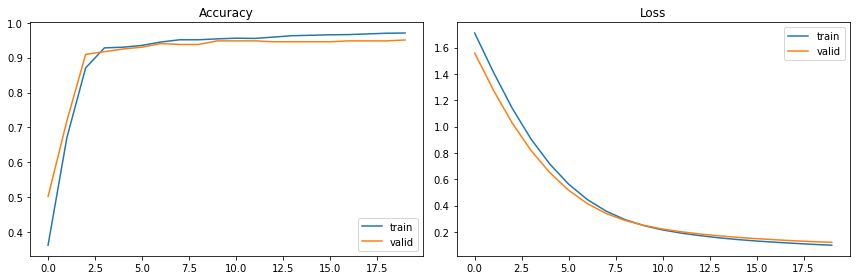

In [31]:
plot_acc(history)

In [32]:
y_pred = dl_model.predict(X_test)

16/16 [==============================] - 0s 4ms/step


In [33]:
y_pred[0:5] #confidence levels

array([[1.90592483e-02, 2.97269435e-03, 9.73980069e-01, 1.14398904e-03,
        1.32263778e-03, 1.52135186e-03],
       [2.60001631e-03, 1.43433257e-03, 9.93386328e-01, 5.85486472e-04,
        1.38505036e-03, 6.08791539e-04],
       [1.84797472e-03, 1.13351038e-03, 3.42862378e-03, 7.33273430e-03,
        3.04553360e-02, 9.55801785e-01],
       [3.86590720e-03, 8.97540594e-04, 1.60980946e-03, 1.49625279e-02,
        9.48465705e-01, 3.01985480e-02],
       [1.15280109e-03, 7.93426880e-04, 2.38095387e-03, 9.70289886e-01,
        1.08674560e-02, 1.45155005e-02]], dtype=float32)

In [34]:
prediction = pd.DataFrame(y_pred, columns=le.classes_)
prediction.head()

,ck,cm,co,ct,rbt,stl
0,0.019059,0.002973,0.973980,0.001144,0.001323,0.001521
1,0.002600,0.001434,0.993386,0.000585,0.001385,0.000609
2,0.001848,0.001134,0.003429,0.007333,0.030455,0.955802
3,0.003866,0.000898,0.001610,0.014963,0.948466,0.030199
4,0.001153,0.000793,0.002381,0.970290,0.010867,0.014516


In [35]:
y_test[0:5]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [36]:
dl_model.save('model/dl_riya.h5')